In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Load the Pre-trained VGG16 Model (ImageNet)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

In [ ]:
# Step 2: Add custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')  # Adjust for your number of classes
])

In [ ]:
# Step 3: Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0001),  # Use a lower learning rate
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Step 4: Load and Preprocess your Dataset
# Example: using a custom dataset
(ds_train, ds_test), ds_info = tfds.load('rock_paper_scissors', split=['train', 'test'], shuffle_files=True,
                                         as_supervised=True, with_info=True)

In [ ]:
# Preprocessing: Resize images and normalize them
def preprocess(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to 224x224 (VGG16 input size)
    image = image / 255.0  # Normalize to [0, 1] range
    return image, tf.one_hot(label, depth=3)  # One-hot encode labels (adjust for your number of classes)

In [ ]:
# Apply preprocessing to the training and test datasets
ds_train = ds_train.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)
ds_test = ds_test.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Step 5: Train the Model
history = model.fit(ds_train, validation_data=ds_test, epochs=3)

Epoch 1/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 1606s 20s/step - accuracy: 0.8305 - loss: 0.4156 - val_accuracy: 0.9140 - val_loss: 0.2094
Epoch 2/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 1671s 21s/step - accuracy: 1.0000 - loss: 0.0096 - val_accuracy: 0.9140 - val_loss: 0.2124
Epoch 3/3
79/79 ━━━━━━━━━━━━━━━━━━━━ 1590s 20s/step - accuracy: 0.9986 - loss: 0.0070 - val_accuracy: 0.9274 - val_loss: 0.2041


In [ ]:
# Step 6: Evaluate the Model (Testing)
loss, accuracy = model.evaluate(ds_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

12/12 ━━━━━━━━━━━━━━━━━━━━ 211s 17s/step - accuracy: 0.9247 - loss: 0.2028
Test Accuracy: 92.74%


In [ ]:
# Step 7: Predict on the Test Dataset
predictions = model.predict(ds_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 207s 17s/step


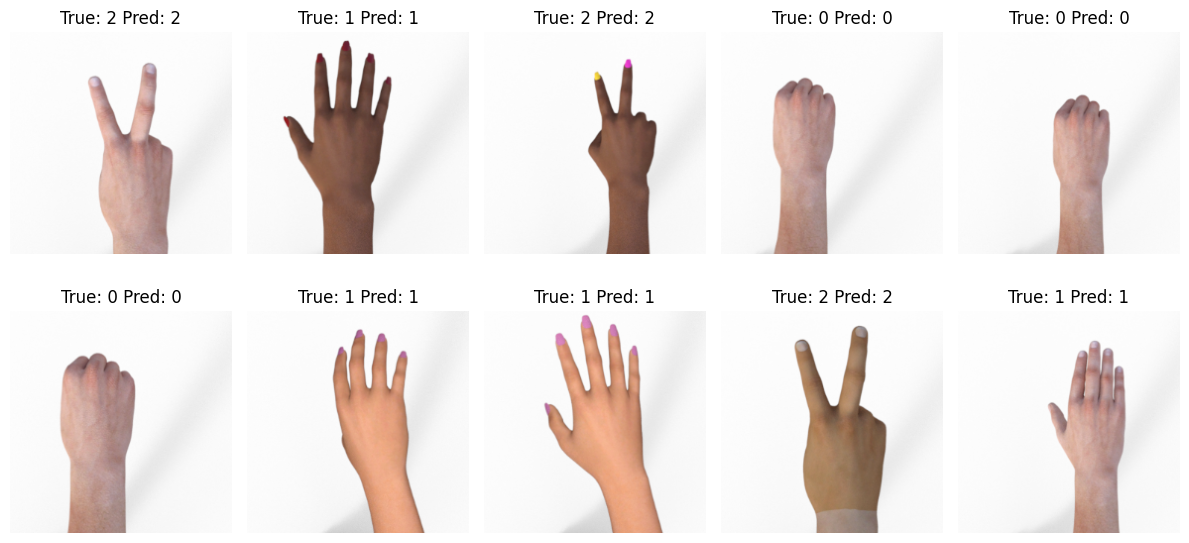

In [ ]:
# Step 8: Visualize Predictions with Input Images
def plot_predictions(images, true_labels, pred_labels):
    plt.figure(figsize=(12, 6))
    for i in range(len(images)):
        plt.subplot(2, 5, i + 1)  # 2 rows, 5 columns
        plt.imshow(images[i])  # Display the image
        plt.axis('off')
        plt.title(f'True: {true_labels[i]} Pred: {pred_labels[i]}')  # Show true and predicted labels
    plt.tight_layout()
    plt.show()

# Get images, true labels, and predictions for the first 10 samples
for images, labels in ds_test.take(1):
    predicted_labels = tf.argmax(predictions[:10], axis=-1)  # Get predicted labels for first 10 samples
    true_labels = tf.argmax(labels[:10], axis=-1)  # Get true labels for first 10 samples

    # Convert images to numpy for plotting
    images = images[:10].numpy()
    predicted_labels = predicted_labels.numpy()
    true_labels = true_labels.numpy()

    # Plot the predictions
    plot_predictions(images, true_labels, predicted_labels)

In [ ]:
# Print the model summary
model.summary()  # This line prints the model architecture


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,985,355 (129.64 MB)

 Trainable params: 6,423,555 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 12,847,112 (49.01 MB)